# Bagging and random forest

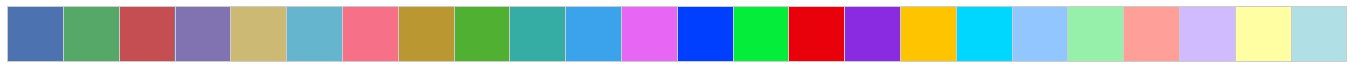

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

# will be in numpy >= 1.15
@contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)
        
def ndprint(a, precision=3):
    with printoptions(precision=precision, suppress=True):
        print(a)

In [2]:
from sklearn import datasets, metrics, model_selection as mdsel, tree, ensemble

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

In [3]:
data, target = datasets.load_digits(return_X_y=True)

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

In [22]:
def write_answer(result, ans_ind):
    path = f'out/18_bagging_and_decision_trees_answer{ans_ind}.txt'
    result_str = result if isinstance(result, str) else str(result)
    with open(path, "w") as fout:
        fout.write(result_str)

##### 1.

Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

In [25]:
%%time
dt_classifier = tree.DecisionTreeClassifier()
result_1 = mdsel.cross_val_score(dt_classifier, data, y=target, cv=10).mean()
result_1      

Wall time: 280 ms


In [26]:
write_answer(result_1, 1)

##### 2.

Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [39]:
%%time
bag_classifier = ensemble.BaggingClassifier(base_estimator=dt_classifier, n_estimators=100)
result_2 = mdsel.cross_val_score(bag_classifier, data, y=target, cv=10, n_jobs=3).mean()

Wall time: 9.81 s


In [40]:
write_answer(result_2, 2)

##### 3.

Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [41]:
%%time
features = data.shape[1]
max_features = np.sqrt(features)/features

bag_classifier = ensemble.BaggingClassifier(base_estimator=dt_classifier, n_estimators=100, max_features=max_features)
result_3 = mdsel.cross_val_score(bag_classifier, data, y=target, cv=10, n_jobs=3).mean()

Wall time: 3.81 s


In [42]:
write_answer(result_3, 3)

##### 4.

Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$ признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.

In [44]:
%%time
dt_classifier = tree.DecisionTreeClassifier(max_features=max_features)
bag_classifier = ensemble.BaggingClassifier(base_estimator=dt_classifier, n_estimators=100)

result_4 = mdsel.cross_val_score(bag_classifier, data, y=target, cv=10, n_jobs=3).mean()

Wall time: 4.38 s


In [45]:
write_answer(result_4, 4)

In [46]:
result_4

0.9533112247036397

##### 5.

Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

In [48]:
%%time
rf_classifier = ensemble.RandomForestClassifier(n_estimators=100)
result_5 = mdsel.cross_val_score(rf_classifier, data, y=target, cv=10, n_jobs=3).mean()
print(result_5)

0.946651081494043
Wall time: 3.86 s


In [55]:
np.hstack([np.array([1, 2, 3, 5, 8]), np.arange(10, 101, 10)] )

array([  1,   2,   3,   5,   8,  10,  20,  30,  40,  50,  60,  70,  80,
        90, 100])

In [87]:
cv = 10
n_jobs = 3
n_estimators = np.hstack([np.array([1, 2, 3, 5, 8]), np.arange(10, 101, 10)] )
max_features = np.hstack([np.array([1, 2, 3, 5, 8]), np.arange(10, 65, 5)] )
max_depth = np.array([1, 2, 3, 5, 7, 10, 14, 18, 23, 32])

print(n_estimators.shape[0], max_features.shape[0], max_depth.shape[0])

15 16 10


In [96]:
def get_score(estimator):
    return mdsel.cross_val_score(estimator, data, y=target, cv=cv, n_jobs=n_jobs).mean()

def get_rf_by_estimators(n_estimators):
    return ensemble.RandomForestClassifier(n_estimators=n_estimators)

def get_rf_by_depth(n_estimators, max_depth):
    return ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

def get_rf_by_features(n_estimators, max_depth, max_features):
    return ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

In [108]:
%%time
xs = n_estimators
ys_rf = [get_score(get_rf_by_estimators(n)) for n in xs]

Wall time: 40.6 s


Text(0.5,1,'Score by n_estimators')

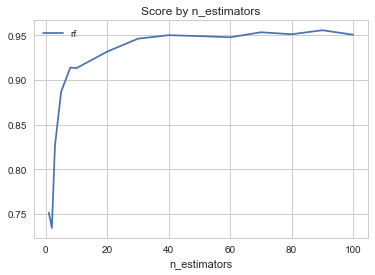

In [109]:
plt.plot(xs, ys_rf, label='rf')
plt.xlabel('n_estimators')
plt.legend()
plt.title('Score by n_estimators')

In [110]:
%%time
xs = max_depth
ys_rf = [get_score(get_rf_by_depth(100, d)) for d in xs]

Wall time: 35.4 s


Text(0.5,1,'Score by max_depth')

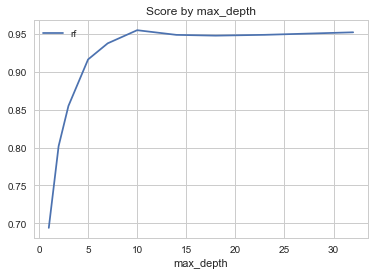

In [111]:
plt.plot(xs, ys_rf, label='rf')
plt.xlabel('max_depth')
plt.legend()
plt.title('Score by max_depth')

In [112]:
%%time
xs = max_features
ys_rf = [get_score(get_rf_by_features(100, 15, f)) for f in xs]

Wall time: 1min 34s


Text(0.5,1,'Score by max_features')

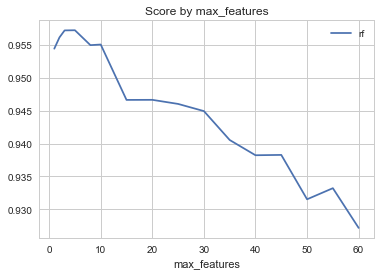

In [113]:
plt.plot(xs, ys_rf, label='rf')
plt.xlabel('max_features')
plt.legend()
plt.title('Score by max_features')

In [99]:
parameters_grid = {
    'n_estimators': [20, 40, 75, 100],
    'max_features': [7, 8, 10, 13, 15],
    'max_depth': [8, 10, 15, 20],
}
randomized_grid_cv = mdsel.GridSearchCV(
    rf_classifier, parameters_grid, scoring='accuracy', cv=cv, n_jobs=3
)

In [100]:
%%time
randomized_grid_cv.fit(data, target)

Wall time: 1min 50s


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [20, 40, 75, 100], 'max_features': [7, 8, 10, 13, 15], 'max_depth': [8, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [101]:
print(randomized_grid_cv.best_score_)
print(randomized_grid_cv.best_params_)

0.9554813578185866
{'max_depth': 15, 'max_features': 7, 'n_estimators': 100}


На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера (это будет ответ в п.5)

1) Случайный лес сильно переобучается с ростом количества деревьев

2) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев

3) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

5) При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.

6) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.

7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

How to submit
When you're ready to submit, you can upload files for each part of the assignment on the "My submission" tab.

In [114]:
write_answer('2 3 4 7', 5)